# Climate Change

The IPCC (Intergovernmental Panel on Climate Change) estimates that SE Asia will be one of the regions where climate change will be felt most overall (see the report – Climate Change 2014: Impacts, Adaptation and Vulnerability).

Mostly due to increase in temperature and temperature extremes.

Moreover, precipitation is expected to become more variable:

"In South Asia, the frequency of heavy precipitation events is increasing, while
light rain events are decreasing."

To adapt to climate change, stakeholders can use PalmSim to estimate the effect of climate change on oil palm.

In this demo we will estimate oil palm production in North Sumatra for past and future weather.

We will first consider the past. Then we (you) will consider the future weather for different levels of weather extremity. 

# Past Weather

Let us first import past weather data and calculate oil palm production.

*Note, this weather data is for demo purposes and is based on actual past weather data but not the actual past weather data.*

In [1]:
# to allow us to work with spreadsheets import the "pandas" library
import pandas as pd

# to allow us to make plots, import a plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# read-in the csv-file
weather_past = pd.read_csv('./input/North Sumatra.csv',index_col='Date')
weather_past.index = pd.to_datetime(weather_past.index)

What kind of trends and events do you observe?

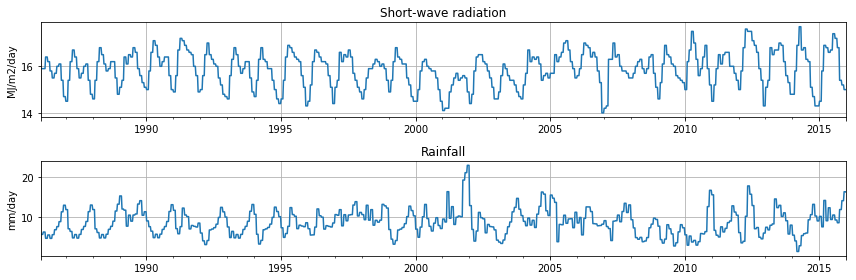

In [2]:
fig, axes = plt.subplots(2,1,figsize=(12,4))

ax = axes[0]

s = weather_past['solar (MJ/m2/day)']
s.plot(ax=ax)
ax.grid()
ax.set_title('Short-wave radiation')
ax.set_xlabel('')
ax.set_ylabel('MJ/m2/day')

ax = axes[1]

s = weather_past['precip (mm/day)']
s.plot(ax=ax)
ax.grid()
ax.set_title('Rainfall')
ax.set_xlabel('')
ax.set_ylabel('mm/day')
    
plt.tight_layout()

Note the dip in radiation around 2001, the annual cycle and the dip in rainfall around 2009 and 2014.

Overall the precipitation is ample for oil palm: on average around 280 mm per month with minima of around 100 mm per month.

For reference, evapotranspiration is little in comparison at around 100 mm per month.

However, it turns out that in the year 2008--2010 there were some dry spells and a short severe drought in 2014. These dry spells where most likely noticeable in the oil palm production.


# Past Production

Given the ample rainfall we expect little water stress due to soil water deficit.

Let us simulate a field of oil palm to calculate how exactly.

In [3]:
import sys
sys.path.append('..')

from palmsim import PalmField

weather_data = weather_past

year_of_planting = weather_data.index.year[0]

# 1. Initialize the model
p = PalmField(year_of_planting=year_of_planting, dt=10)

# 2. Couple the solar radiation data:
p.weather.radiation_series = weather_data['solar (MJ/m2/day)']
p.weather.rainfall_series = weather_data['precip (mm/day)']

# 3. Run the model
df = p.run(duration=30*365)

# 4. Make a copy of results for later use
df_past = df.copy()

..\palmsim\components\fronds.py:205: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ''')
..\palmsim\components\fronds.py:221: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ''')
..\palmsim\components\fronds.py:263: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ''')
..\palmsim\components\trunk.py:103: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ''')
..\palmsim\components\trunk.py:116: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/lo

### Past Soil Water Status

Naturally for crop production a good soil water status is crucial.

As expected, given this rainfall the precipitation is ample.

The water deficit is at at most around 150 mm.

Given a water holding capacity (WHC) of 600 mm for the whole rooted zone the soil operates around field capacity.

Note, a WHC of 600 mm is attained for a rooting depth of 3 meters and a WHC of 200mm/m of the soil.

The soil moisture content (here defined as the ratio of available water to the WHC) is never below 80%.

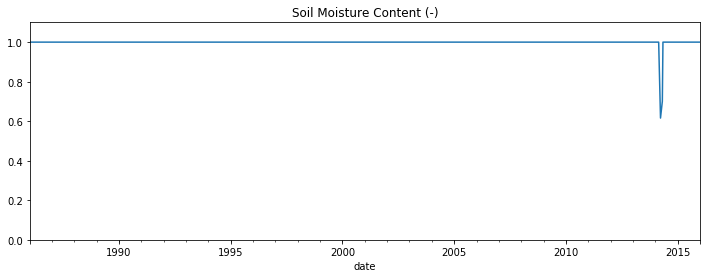

In [4]:
ax = df['soil_moisture_content (1)'].plot(figsize=(12,4))
ax.set_title('Soil Moisture Content (-)');
ax.set_ylim(0,1.1);

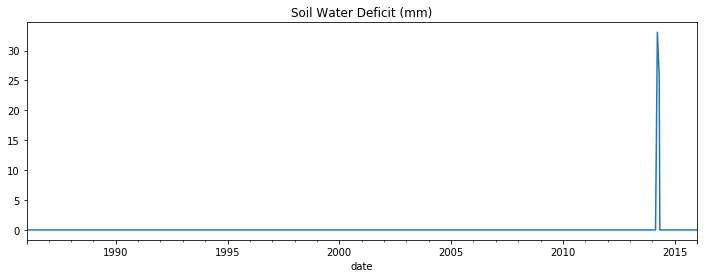

In [5]:
ax = df['soil_water_deficit (mm)'].plot(figsize=(12,4))
ax.set_title('Soil Water Deficit (mm)');

### Past Production

Given the generally ample rainfall and radiation the production is close to the potential production.

Note the fluctuations in yield related to the fluctuations in solar radiation.

Text(0.5, 1.0, 'FFB production (t/ha/yr)')

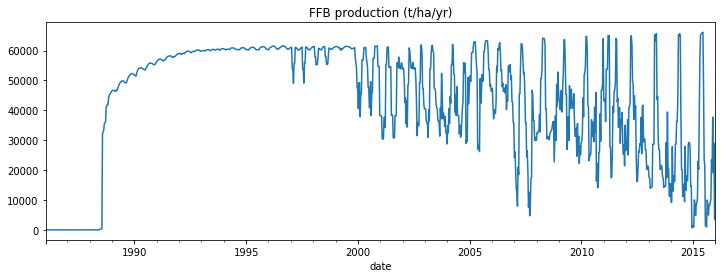

In [6]:
ax = df['generative_FFB_production (t/ha/yr)'].plot(figsize=(12,4))
ax.set_title('FFB production (t/ha/yr)')

Text(0.5, 1.0, 'Bunch Counts (1/ha/month)')

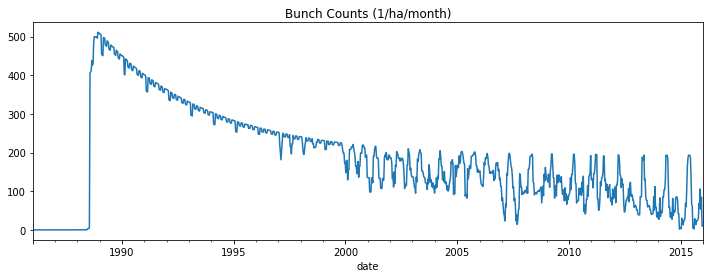

In [7]:
ax =df['generative_bunch_count (1/ha/mo)'].plot(figsize=(12,4))
ax.set_title('Bunch Counts (1/ha/month)')

# Weather

As an estimate for the future weather, **let us assume that the variability of precipitation will increase**.

That is to say, where for the **past weather we had a mean precipitation** of around 260 mm/month ~= 8mm/day and extremes arpound 100 to 400 mm/momth:

In [8]:
# let us view summary statistics
weather_past['precip (mm/day)'].describe()

count    10927.000000
mean         8.634850
std          3.237813
min          1.300000
25%          6.350000
50%          8.193548
75%         10.583871
max         22.993333
Name: precip (mm/day), dtype: float64

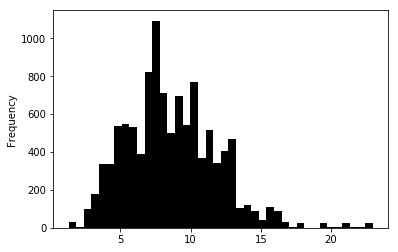

In [9]:
# let us view the histogram
weather_past['precip (mm/day)'].plot(kind='hist',bins=40,color='black');

Text(0.5, 1.0, 'Rainfall')

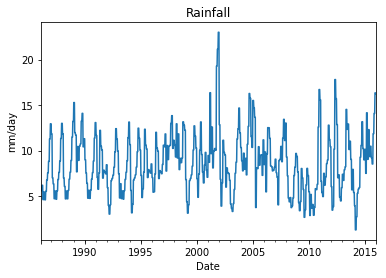

In [10]:
# let us view the time-series

s = weather_past['precip (mm/day)']
ax = s.plot()
ax.set_ylabel('mm/day')
ax.set_title('Rainfall')
    

### Future scenario definition

Let us consider the following hypothetical future weather scenario:

Let us assume that the mean precipitation stays the same but the extremes will be more severe:

More extreme **dry spells with ~0 mm/month and months of extreme rainfall with over 500 mm/month.**

Let us make such a scenario based on the past weather.

In [11]:
# technical detail, we will scale the weather time-series
# relative to the mean
# starting at a scaling of 1 (identical to past)
# ending with a scaling > 1 -- more severe weather extremes
# e.g. 1.5, 1.5 times more extreme than past

weather_future = weather_past.copy()
weather_future.index += pd.DateOffset(years=30)

import numpy as np

extremity_indices = (1,2)

def scale(x,scaling=(1,1)):
    ''' Scale a time-series away from its mean.
    
    a0: The scaling for the start of the series.
    a1: The scaling for the end of the series.
    '''
    s0,s1 = scaling
    s = np.linspace(s0,s1,len(x))
    return s*(x-x.mean())+x.mean()

weather_future['precip (mm/day)'] = scale(weather_future['precip (mm/day)'],
                                      extremity_indices)

mask = weather_future['precip (mm/day)'] < 0
weather_future.loc[mask,'precip (mm/day)'] = 0

Now that we have created the hypothetical future weather let us do the following,

**Let us view the properties of the hypothetical future precipitation:**

In [12]:
# let us view summary statistics
weather_future['precip (mm/day)'].describe()

count    10927.000000
mean         8.711136
std          5.031581
min          0.000000
25%          5.489170
50%          7.981867
75%         11.499203
max         30.627273
Name: precip (mm/day), dtype: float64

Note, there are now extremely dry months with verly little rain.

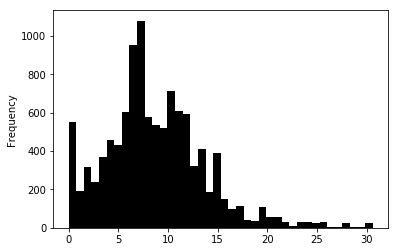

In [13]:
# let us view the histogram
weather_future['precip (mm/day)'].plot(kind='hist',bins=40,color='black');

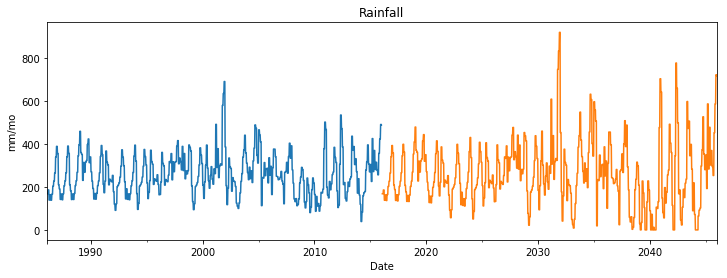

In [14]:
# let us view the time-series

fig, ax = plt.subplots(figsize=(12,4))

s = 30*weather_past['precip (mm/day)']
ax = s.plot()
ax.set_ylabel('mm/mo')
ax.set_title('Rainfall')

s = 30*weather_future['precip (mm/day)']
s.plot(ax=ax)

Here, **the hypothetical dry spells around 2040 will most likely severely affect oil palm production.**

# Future Production

In [15]:
weather_data = weather_future

year_of_planting = weather_data.index.year[0]

# 1. Initialize the model
p = PalmField(year_of_planting=year_of_planting, dt=10)

# 2. Couple the solar radiation data:
p.weather.radiation_series = weather_data['solar (MJ/m2/day)']
p.weather.rainfall_series = weather_data['precip (mm/day)']

# 3. Run the model
df = p.run(duration=30*365)

# 4. Make a copy of results for later use
df_future = df.copy()

### Future Soil Water Status

The increased severity of the dry spells results in periodic critical water deficits and low soil moisture contents.

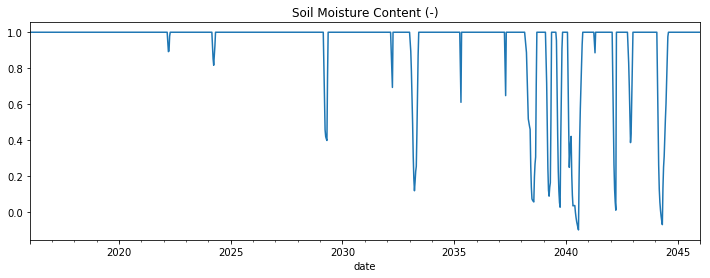

In [16]:
ax = df['soil_moisture_content (1)'].plot(figsize=(12,4))
ax.set_title('Soil Moisture Content (-)');

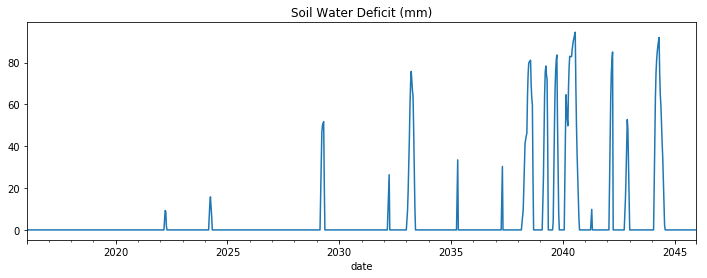

In [17]:
ax = df['soil_water_deficit (mm)'].plot(figsize=(12,4))
ax.set_title('Soil Water Deficit (mm)');

These deficits will definitely limit production.

### Future Production

For the first few years in our scenario the oil palms produce at a potential rate.

However as the hypothetical weather becomes more severe the production will become (very) water-limited due to a reduction of photosynthesis (stomatal closure) and bunch counts (low sex ratio, abortion).

In this hypothetical scenario the yield drops from 40 tonnes FFB/ha/year to a low 10 tonnes around 2040!

Might irrigation be required to combat the drought?

Text(0.5, 1.0, 'FFB production (t/ha/yr)')

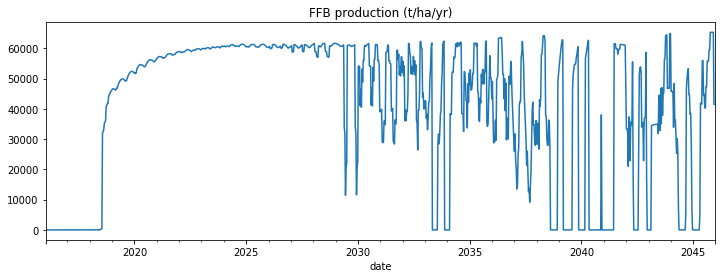

In [18]:
ax = df['generative_FFB_production (t/ha/yr)'].plot(figsize=(12,4))
ax.set_title('FFB production (t/ha/yr)')

Text(0.5, 1.0, 'Bunch Counts (1/ha/month)')

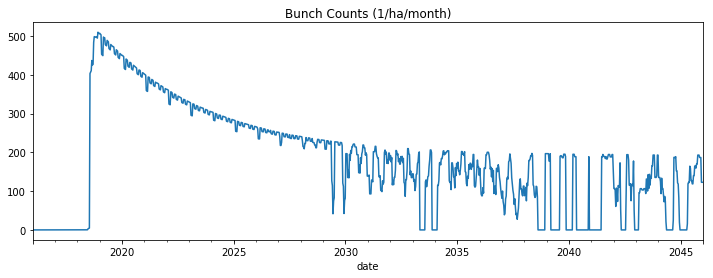

In [19]:
ax =df['generative_bunch_count (1/ha/mo)'].plot(figsize=(12,4))
ax.set_title('Bunch Counts (1/ha/month)')

We see dips in bunch count (1/ha/month) related to dips in the female fraction and increased inflorescence abortion.

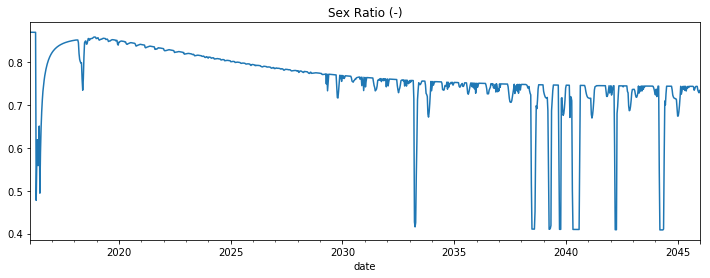

In [20]:
ax = df['generative_female_fraction (1)'].plot(figsize=(12,4))
ax.set_title('Sex Ratio (-)');

Text(0.5, 1.0, 'Inflorescence abortion (1/month)')

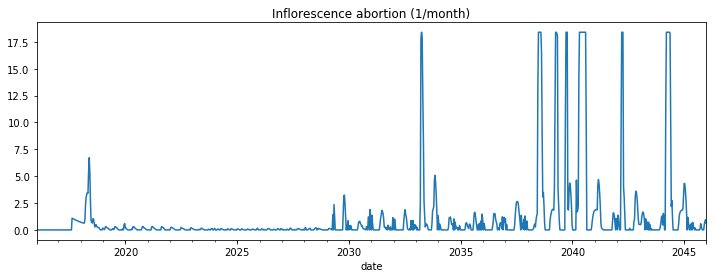

In [21]:
ax = (30*df['generative_inflorescence_abortion_fraction (1)']).plot(figsize=(12,4))
ax.set_title('Inflorescence abortion (1/month)')

Text(0.5, 1.0, 'Bunch failure faction (1/month)')

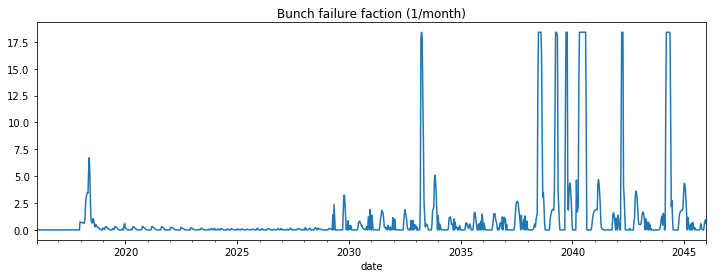

In [22]:
ax = (30*df['generative_bunch_failure_fraction (1)']).plot(figsize=(12,4))
ax.set_title('Bunch failure faction (1/month)')

# Comparison

Now let us simply compare past and future:

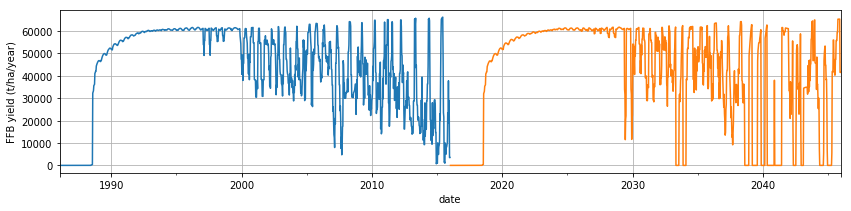

In [23]:
column = 'generative_FFB_production (t/ha/yr)'

ax = df_past[column].plot(figsize=(14,3))

df_future[column].plot(ax=ax)

ax.grid()
ax.set_ylabel('FFB yield (t/ha/year)');

## Important note

Although this example shows possible implications of climate change the considered future weather is hypothetical.

However, probably there will be significant implications and it is thus important to be able to estimate them in advance.